In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
from  sklearn.metrics import mean_absolute_error
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.metrics import mean_absolute_error


In [2]:

ticker='5EFCHI'
period1=int(time.mktime(datetime.datetime(1991,1,1).timetuple()))
period2=int(time.mktime(datetime.datetime(2023,2,3).timetuple()))

interval='1mo' #1d #1wk

query_string= f'https://query1.finance.yahoo.com/v7/finance/download/%{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'


df=pd.read_csv(query_string)
df





,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-01,1504.000000,1600.000000,1425.000000,1580.000000,1580.000000,0
1,1991-02-01,1577.000000,1762.000000,1565.000000,1760.000000,1760.000000,0
2,1991-03-01,1746.000000,1855.000000,1726.000000,1816.000000,1816.000000,0
3,1991-04-01,1815.000000,1859.000000,1762.000000,1779.000000,1779.000000,0
4,1991-05-01,1793.000000,1864.400024,1785.500000,1861.800049,1861.800049,0
...,...,...,...,...,...,...,...
381,2022-10-01,5697.470215,6293.149902,5654.439941,6266.770020,6266.770020,1530909300
382,2022-11-01,6329.759766,6743.600098,6191.729980,6738.549805,6738.549805,1663727000
383,2022-12-01,6784.600098,6823.100098,6388.229980,6473.759766,6473.759766,1448945200
384,2023-01-01,6521.069824,7117.529785,6518.209961,7082.419922,7082.419922,1248137000


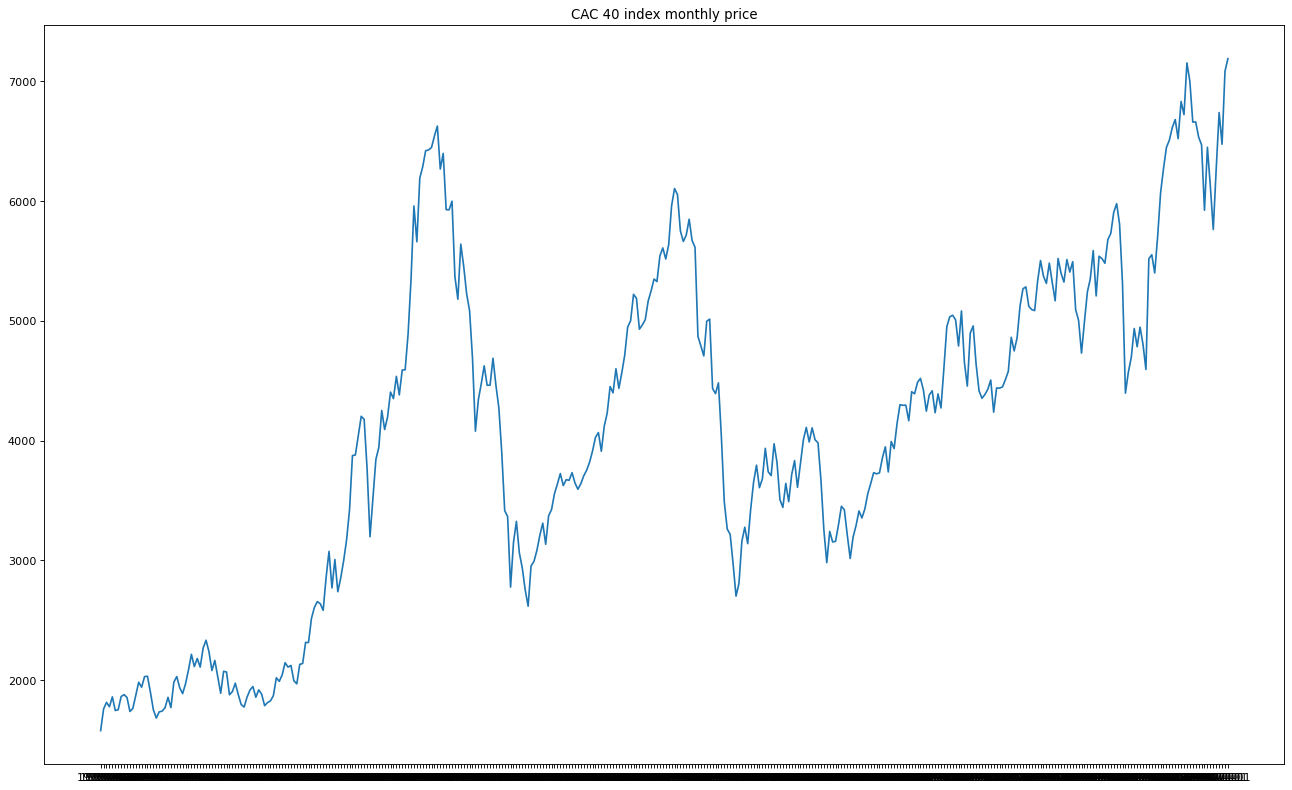

In [31]:
CAC40_Price=df['Close']
Date=df['Date']
fig, ax = plt.subplots(figsize=(20,12), dpi= 80) #fixing width and height of the coming plots
ax.plot(Date, CAC40_Price)
plt.title('CAC 40 index monthly price') #setting the plot's title
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #remove days from Date in x-axis
plt.show() #show the plot

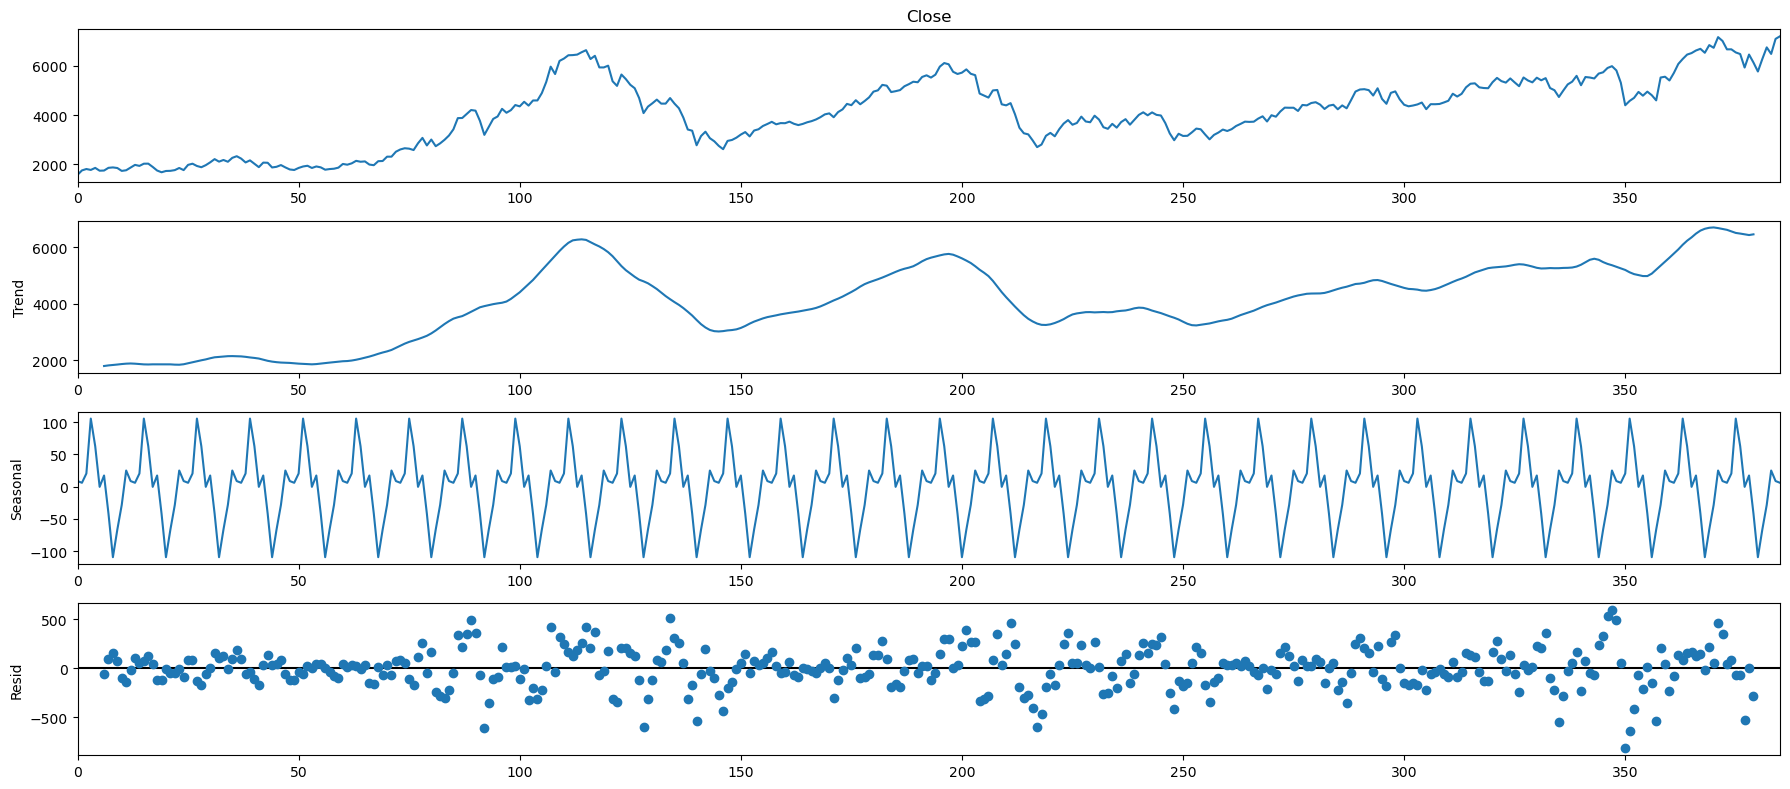

In [4]:
#@title ##**Time Series Decomposition** { display-mode: "form" }
rcParams['figure.figsize'] = 18, 8 #fix the dimensions of the coming plots
decomposition = sm.tsa.seasonal_decompose(CAC40_Price, model='Additive', period=12) #decomposing the CAC 40 signal using a 12-month moving average
fig = decomposition.plot() # plot the decomposition of the signal
plt.show() #show the plot

Comment:
From the ACF plot we can see that there is no seasonality in the data and we can notice that the first 25 lags have significant correlation with the original series.
Comment:
We notice that the first lag contributes in a major way to the original series. Other lags contribute in a very small way.


C:\Users\SS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


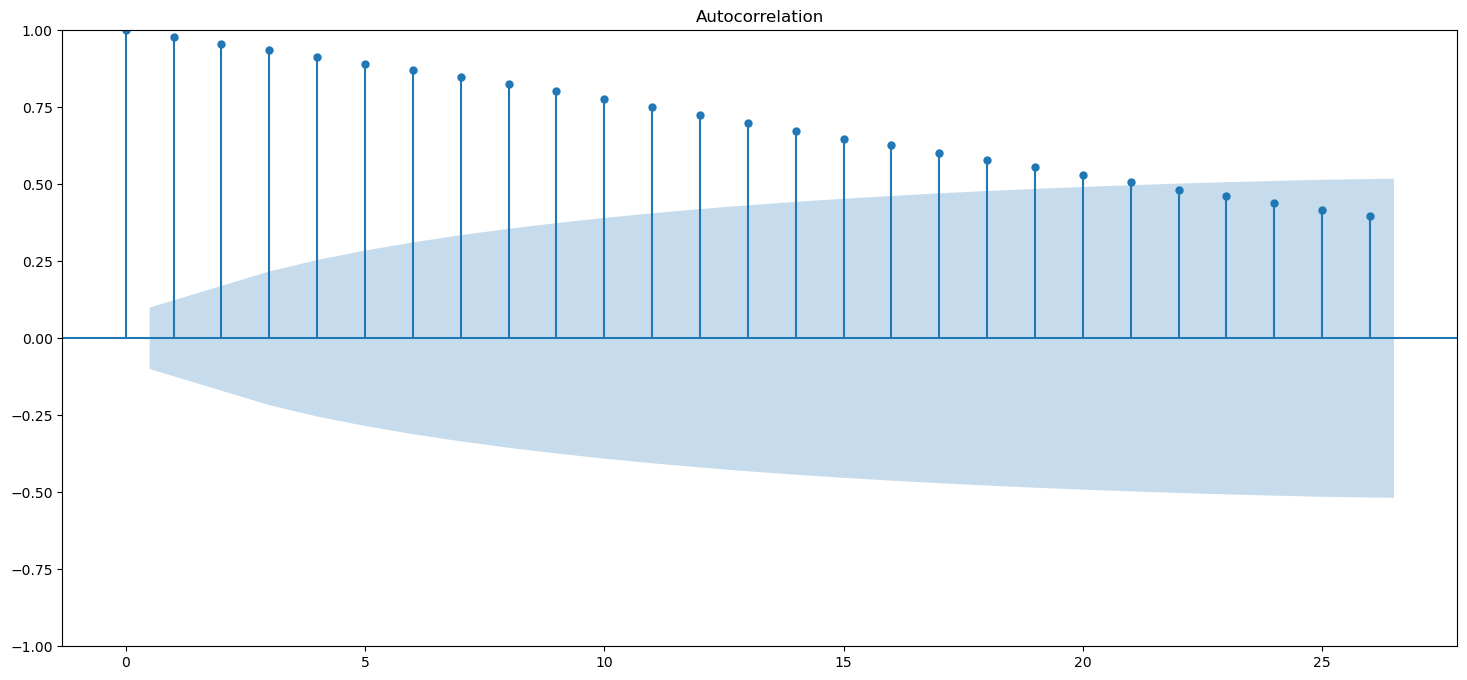

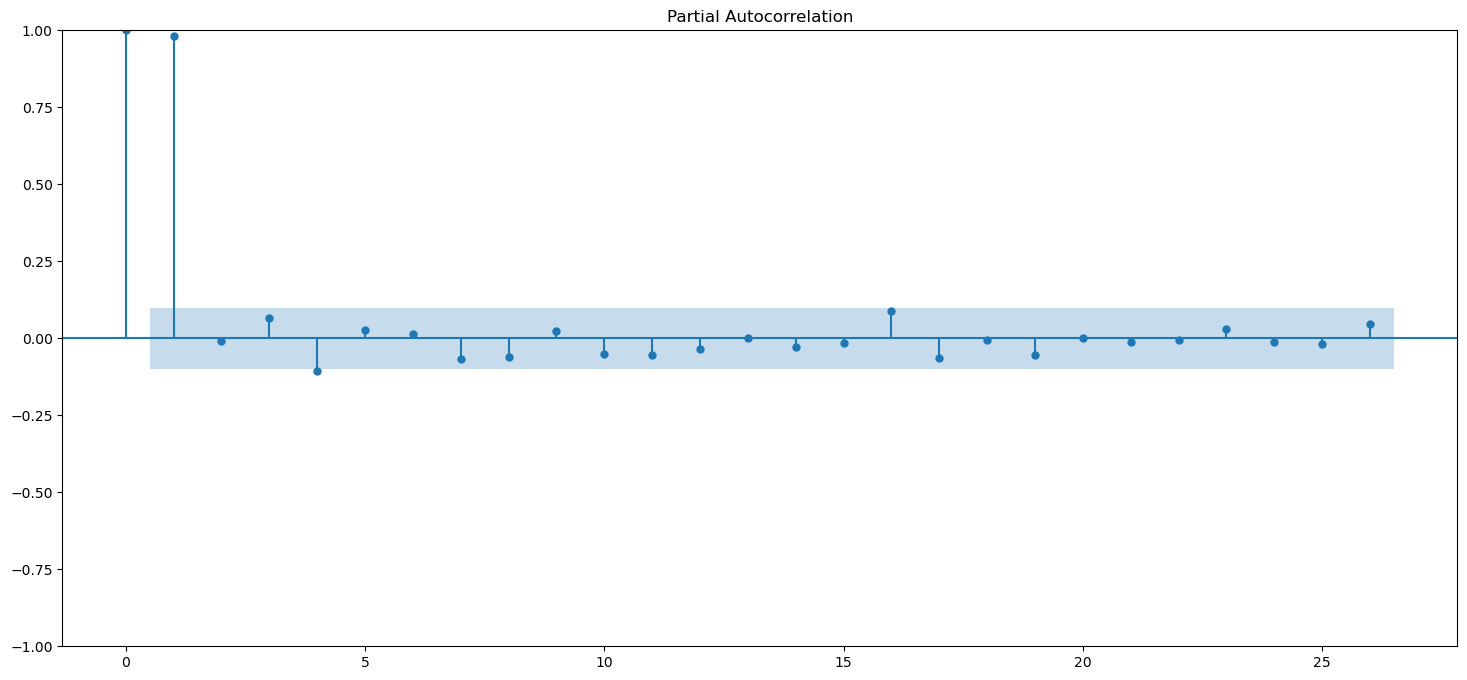

In [5]:

#@title ##**Check for Autocorrelation and Partial Autocorrelation** { display-mode: "form" }

acf=plot_acf(CAC40_Price) #Plot the Autocorrelation function
print("Comment:")
print("From the ACF plot we can see that there is no seasonality in the data and we can notice that the first 25 lags have significant correlation with the original series.")
pacf=plot_pacf(CAC40_Price) #Plot the Partial Autocorrelation function
print("Comment:")
print("We notice that the first lag contributes in a major way to the original series. Other lags contribute in a very small way.")

In [6]:
#@title ##**Check for Stationarity with Dickey-Fuller Test (threshold of 5%)** { display-mode: "form" }
print('Results of Dickey-Fuller Test:')
dftest = adfuller(CAC40_Price, autolag='AIC') #perform stationary test
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) #output important values relative to the stationarity test
print (dfoutput) #print the output

#Comment
print("As the p-value is not less than our threshold of 5% we fail to reject the null-hypothesis, thus this series is non-stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -1.239583
p-value                          0.656341
#Lags Used                       0.000000
Number of Observations Used    385.000000
dtype: float64
As the p-value is not less than our threshold of 5% we fail to reject the null-hypothesis, thus this series is non-stationary


Test Statistic                -1.881000e+01
p-value                        2.022474e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.840000e+02
dtype: float64
As the p-value is less than 1% we reject the null-hypothesis, thus the log-difference is stationary with 99% confidence!


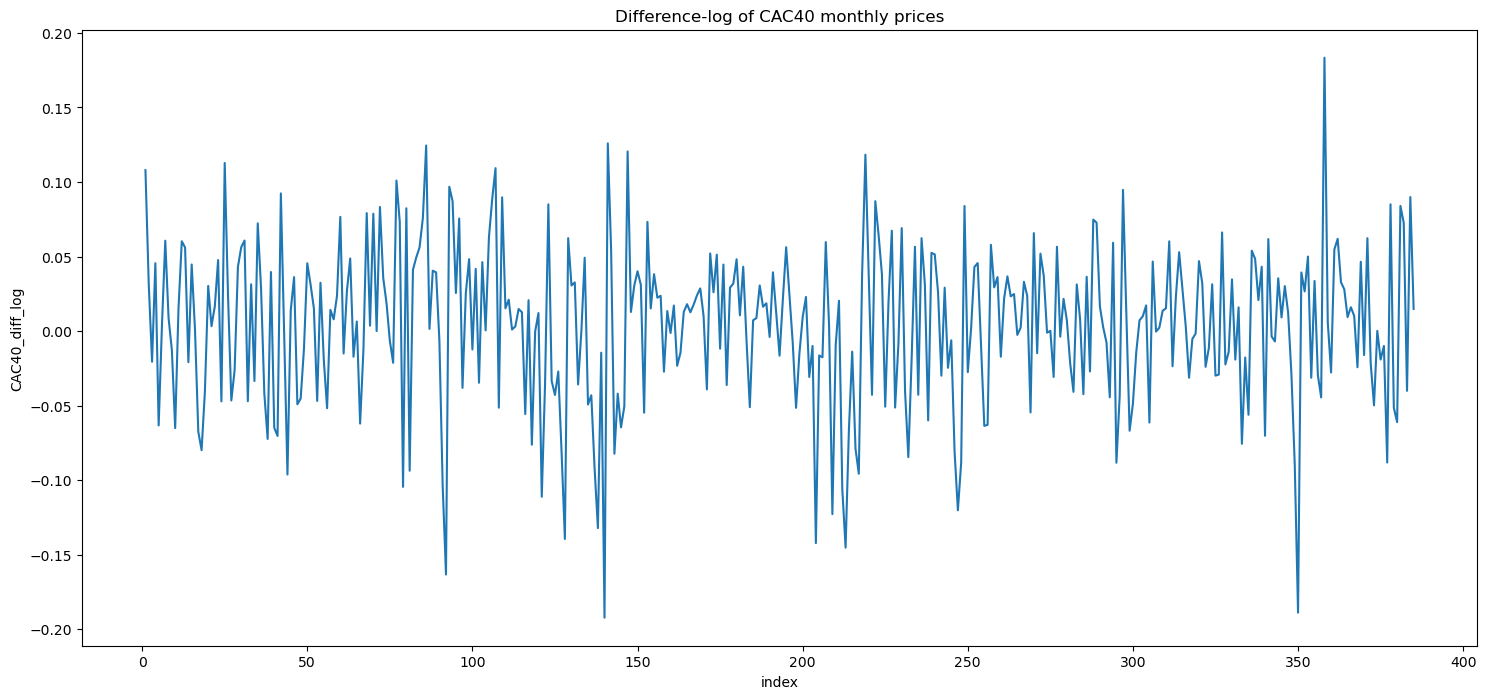

In [7]:
#@title ##**Make the Series Stationary by Differencing its Log** { display-mode: "form" }

#Differenceing the Log
CAC40_log=np.log(CAC40_Price) #log the CAC 40 price data
CAC40_diff_log = np.log(CAC40_Price) - np.log(CAC40_Price).shift() #First difference of log price data of CAC 40 
plt.plot(CAC40_diff_log) #plotting the difference Log
plt.xlabel('index') #labeling the x-axis
plt.ylabel('CAC40_diff_log') #labeling the y-axis
plt.title('Difference-log of CAC40 monthly prices') #giving title to plot

#Check for stationarity
dftest = adfuller(CAC40_diff_log[1:], autolag='AIC') #Test for Diff_log stationarity
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) #output important values relative to the stationarity test
print (dfoutput)

#Comment
print("As the p-value is less than 1% we reject the null-hypothesis, thus the log-difference is stationary with 99% confidence!")

In [8]:
#@title ##**Split Data** { display-mode: "form" }
#@markdown **Choose the Split ratio for train/test:**
Split_ratio= 0.9 #@param {type: "slider", min:0, max:1, step:0.1}
train= CAC40_Price[:int(Split_ratio*len(CAC40_Price))] # CAC40 price Training Data
test= CAC40_Price[int(Split_ratio*len(CAC40_Price)):] # CAC40 price Test data

     

In [9]:
#@title ##**Automatically discover the optimal order for an ARIMA model** { display-mode: "form" }

best=auto_arima(train, test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True) #The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model.

     

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4653.644, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4649.509, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4650.236, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4650.230, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4648.869, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4651.821, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.683 seconds


In [10]:
#@title ##**Fit the Best ARIMA model** { display-mode: "form" }

model=ARIMA(train, order=best.order).fit() #fit the best ARIMA model

     

In [11]:
#@title ##**Making Predictions** { display-mode: "form" }

pred= model.predict(start=len(train), end=(len(CAC40_Price)-1),dynamic=True) #Predict based on the Best ARIMA model and the training set


In [12]:
#@title ##**Evaluating the ARIMA model** { display-mode: "form" }

mae= mean_absolute_error(test, pred) #Calculating the Mean Absolute Error (MAE) between the test set and the predictions

print('MAE: %f' %mae) #Printing the MAE value
     

MAE: 703.287673


Comment:
We notice that the predictions is almost linear and captures the trend but not the noise because we're trying to predict many steps ahead. In the next model we will try to predict one step forward based on a training window.


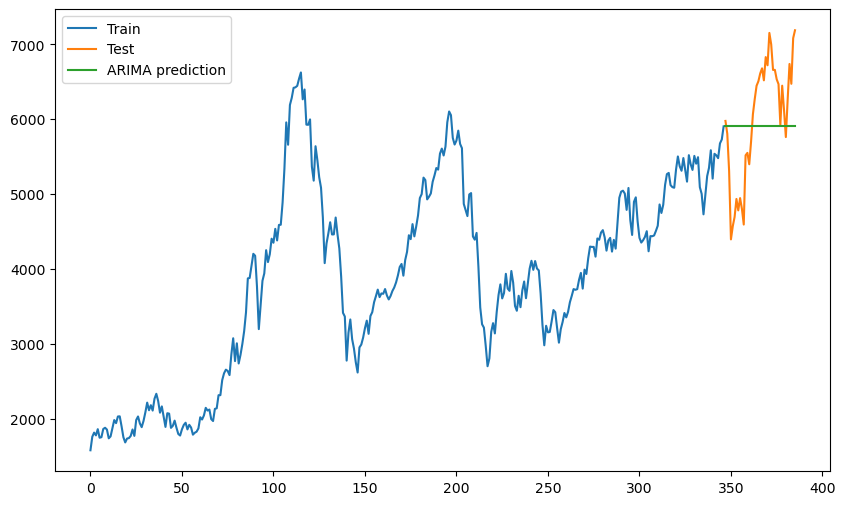

In [13]:
#@title ##**Plotting the Prediction vs Test** { display-mode: "form" }

train.plot(legend=True, label='Train', figsize=(10,6)) #plot the training data

test.plot(legend=True, label= 'Test') #plot the test data

pred.plot(legend=True, label='ARIMA prediction') #plot the predictions

print("Comment:")
print("We notice that the predictions is almost linear and captures the trend but not the noise because we're trying to predict many steps ahead. In the next model we will try to predict one step forward based on a training window.")
     

# Time Series Forecasting with LSTMs

In [20]:
#@title ##**Standardize and Split the Data** { display-mode: "form" }
 #@markdown **Choose the Split ratio for train/test:**
Split_ratio= 0.8 #@param {type: "slider", min:0, max:1, step:0.1}
data_mean=CAC40_Price.mean()
data_std=CAC40_Price.std()
CAC40_Price=(CAC40_Price-data_mean)/data_std #Standardizing data
train= CAC40_Price[0:int(Split_ratio*len(CAC40_Price[1:]))] # CAC 40 Training Data
test= CAC40_Price[int(Split_ratio*len(CAC40_Price[1:])):] # CAC 40 price Testing Data
CAC40_Price=(CAC40_Price*data_std) + data_mean #convert data to original scale
CAC40_Price
CAC40_Price=pd.DataFrame(CAC40_Price)
CAC40_Price

,Close
0,1580.000000
1,1760.000000
2,1816.000000
3,1779.000000
4,1861.800049
...,...
381,6266.770020
382,6738.549805
383,6473.759766
384,7082.419922


In [21]:
#@title ##**Preparing Windowed Data for LSTM** { display-mode: "form" }

def create_dataset(dataset, time_steps): #function converting original data into a windowed dataset 
	dataX, dataY = [], []
	for i in range(len(dataset)-time_steps-1):
		a = dataset.iloc[i:(i+time_steps), 0]
		dataX.append(a)
		dataY.append(dataset.iloc[i + time_steps, 0])
	return np.array(dataX), np.array(dataY)


In [22]:
#@title ##**Preparing Data for LSTM** { display-mode: "form" }
#@markdown **Choose the Time steps to look-back:**
time_steps = 4 #@param {type: "slider", min:0, max:30, step:1}
# reshape into X=t and Y=t+time_steps
X_train, y_train = create_dataset(train, time_steps) #Prepare training data
X_test, y_test = create_dataset(test, time_steps) #Prepare testing data

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) 
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_test_0=X_test[0][0]

In [23]:
#@title ##**Build LSTM model** { display-mode: "form" }
model = keras.Sequential() #initialization of sequential
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), input_shape=(1, time_steps))) #First layer
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128))) #Second Layer
model.add(keras.layers.Dropout(0.3)) # Droping out 30% of the nodes
model.add(keras.layers.Dense(units=40)) #Third Layer
model.add(keras.layers.Dropout(0.2)) # Droping out 20% of the nodes
model.add(keras.layers.Dense(units=1)) # Output layer
model.compile(loss='mae', optimizer=keras.optimizers.Adam()) # Compile the model with Mean Average Error loss type and Adam optimizer
     

In [24]:
#@title ##**Fit LSTM model** { display-mode: "form" }

history = model.fit( # Fit the model
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/100
5/5 [==============================] - 13s 576ms/step - loss: 0.7704 - val_loss: 0.3374
Epoch 2/100
5/5 [==============================] - 0s 64ms/step - loss: 0.6374 - val_loss: 0.3196
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 0.4885 - val_loss: 0.2706
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 0.3206 - val_loss: 0.1875
Epoch 5/100
5/5 [==============================] - 0s 31ms/step - loss: 0.2374 - val_loss: 0.1453
Epoch 6/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1912 - val_loss: 0.1281
Epoch 7/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1785 - val_loss: 0.1338
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1879 - val_loss: 0.1605
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1752 - val_loss: 0.1585
Epoch 10/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1650 - val_loss: 0.1418
Epoch 11/100
5/5 

Epoch 84/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1321 - val_loss: 0.1172
Epoch 85/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1244 - val_loss: 0.1132
Epoch 86/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1383 - val_loss: 0.1145
Epoch 87/100
5/5 [==============================] - 0s 44ms/step - loss: 0.1331 - val_loss: 0.1125
Epoch 88/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1323 - val_loss: 0.1174
Epoch 89/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1354 - val_loss: 0.1278
Epoch 90/100
5/5 [==============================] - 0s 30ms/step - loss: 0.1297 - val_loss: 0.1125
Epoch 91/100
5/5 [==============================] - 0s 46ms/step - loss: 0.1374 - val_loss: 0.1151
Epoch 92/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1318 - val_loss: 0.1126
Epoch 93/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1340 - val_loss: 0.1157
Epoch 94/1

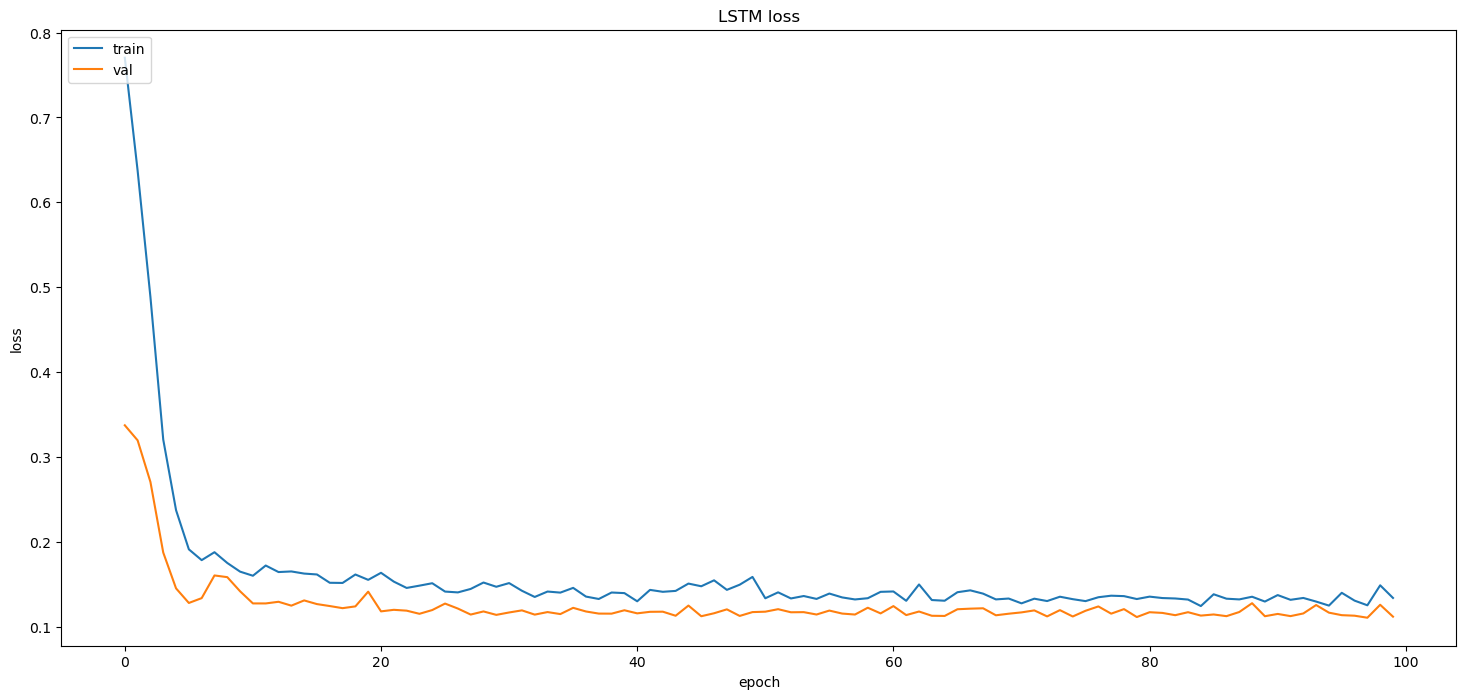

In [25]:
#@title ##**Plot the Loss** { display-mode: "form" }

plt.plot(history.history['loss']) #Plotting the training loss of the model per epoch
plt.plot(history.history['val_loss']) #Plotting the validation loss of the model per epoch
plt.title('LSTM loss') #Giving the plot a title
plt.ylabel('loss') #Giving the y-axis a label
plt.xlabel('epoch') #Giving the x-axis a label
plt.legend(['train', 'val'], loc='upper left') #Giving the plot a legend
plt.show() #Display the plot
     

In [26]:
#@title ##**Predict** { display-mode: "form" }

y_pred = model.predict(X_test)

3/3 [==============================] - 2s 5ms/step


In [27]:
#@title ##**Unstandardizing Data for Predictions plot** { display-mode: "form" }

y_pred=np.array([(y*data_std +data_mean) for y in y_pred]) #unstandardizing y_pred
y_test=np.array([(y*data_std +data_mean) for y in y_test]) #unstandardizing y_test
y_train=np.array([(y*data_std +data_mean) for y in y_train]) #unstandardizing y_train

MAE: 243.51196467658744
Comment:
As we can see the MAE is very low but we can't compare with the previous model's MAE as it's not the same type of forecasting, because here we forcast one step at a time but in the previous one we forecasted many steps forward. 


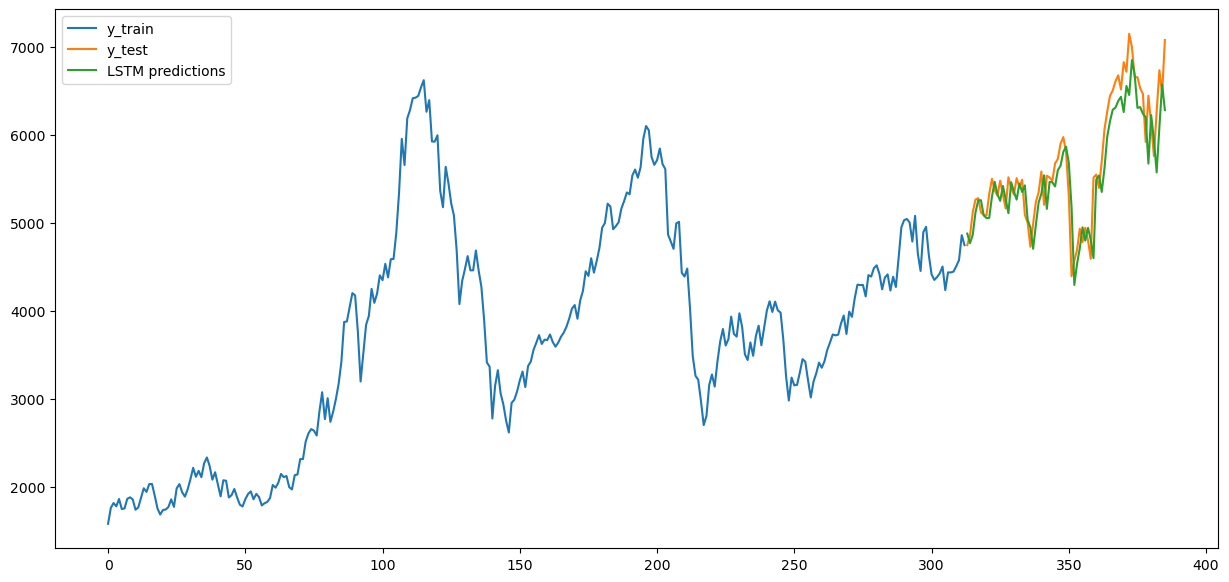

In [30]:
#@title ##**Predictions Plot** { display-mode: "form" }

y_train_0=pd.DataFrame(CAC40_Price["Close"][:len(y_train)+2*time_steps+2], index = CAC40_Price["Close"][:len(y_train)+2*time_steps+2].index) #convert train data into a dataframe and give it a Year-month-day index

y_test_0=pd.DataFrame(y_test, index = CAC40_Price["Close"][len(y_train_0):].index)  #covert test data into a dataframe and give it a Year-month-day index

y_pred_0=pd.DataFrame(y_pred,index=CAC40_Price["Close"][len(y_train_0):].index)  #covert predictions data into a dataframe and give it a Year-month-day index

ax = y_train_0.plot(legend=True, label='y_train', figsize=(15,7)) # plot training data configure plot size

y_test_0.plot(legend=True, label= 'y_test', ax=ax) #plot test data

y_pred_0.plot(legend=True, label='y_pred', ax=ax) #plot predictions

ax.legend(['y_train', 'y_test', 'LSTM predictions' ]) #add legend

mae= mean_absolute_error(y_test_0,y_pred_0)
print("MAE: " + str(mae)) #print MAE of the model

print("Comment:")
print("As we can see the MAE is very low but we can't compare with the previous model's MAE as it's not the same type of forecasting, because here we forcast one step at a time but in the previous one we forecasted many steps forward. ")
